In [163]:
# env = ag , python 3.11.11

In [200]:
import pandas as pd
import numpy as np
import autogluon
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt



In [201]:
'''
Trained for more than 120 min
label = 'Sales'
predictor= TabularPredictor(label=label, path="AutogluonModels/" ).fit(main_train_df,  presets="best")
'''

'\nTrained for more than 120 min\nlabel = \'Sales\'\npredictor= TabularPredictor(label=label, path="AutogluonModels/" ).fit(main_train_df,  presets="best")\n'

### Evaluation Metrics

| Metric                                | Ideal Direction        | Meaning                                                                                                                                          |
| ------------------------------------- | ---------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------ |
| **RMSE (Root Mean Squared Error)**    | ↓ lower = better       | Measures the *typical deviation* between predicted and actual values, penalizing large errors strongly. Same unit as the target (here: “Sales”). |
| **MAE (Mean Absolute Error)**         | ↓ lower = better       | Measures the *average absolute difference* between prediction and truth. More robust to outliers than RMSE.                                      |
| **R² (Coefficient of Determination)** | ↑ closer to 1 = better | Measures how much of the variance in your target is explained by the model (1 = perfect fit, 0 = no better than predicting the mean).            |
| **Pearson r**                         | ↑ closer to 1 = better | Measures *linear correlation* between predicted and true values. Often very close to √R² for linear relationships.                               |


In [202]:
# Evaluate on all the test data takes about 16 min
# The negative values are because AutoGluon uses the same logic for regression and classification and in classification bigger is better, 
# but in regression RMSE and the errors smaller is better therefore it uses negative to sustain the logic. But we know in reality errors are like distance and are always positive.
# RMSE(Root Mean Squared Error): Off by ~524 sales units on average. Compare it to the scale of the target variable. -> Good
# MAE: Average absolute deviation — usually smaller than RMSE (good).
# R²: Excellent! Model explains about 95% of the variation in sales.
# Pearson r: Very strong correlation between predicted and true values.

## Load the data

In [203]:
main_train_df = pd.read_csv("main_train_df.csv")
main_test_df = pd.read_csv("main_test_df.csv")

In [210]:
# Test for preset= medium
# #Trained for 5 min
# I had to disable the stacking that AutoGluon does for best quality due to the time limit.
label = 'Sales'
predictor_5min= TabularPredictor(label=label, path="AutogluonModels_5min/" ).fit(main_train_df, presets="best" , time_limit = 300 , dynamic_stacking=False)


Preset alias specified: 'best' maps to 'best_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.11
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.4.0: Fri Mar 15 00:19:22 PDT 2024; root:xnu-10063.101.17~1/RELEASE_ARM64_T8112
CPU Count:          8
Memory Avail:       2.16 GB / 8.00 GB (27.0%)
Disk Space Avail:   56.25 GB / 228.27 GB (24.6%)
Presets specified: ['best']
Using hyperparameters preset: hyperparameters='zeroshot'
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "/Users/sepideghorbanian/Documents/Semester_5/Research_Project/AutogluonModels_5min"
Train Data Rows:    813764
Train Data Columns: 20
Label Column:       Sales
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int

In [211]:
predictor_5min = TabularPredictor.load("AutogluonModels_5min/")

In [212]:
predictor_5min.leaderboard(silent=True)

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT_BAG_L2,-1052.355552,root_mean_squared_error,56.993399,280.054289,12.063892,84.683253,2,True,4
1,WeightedEnsemble_L3,-1052.355552,root_mean_squared_error,57.001006,280.321175,0.007607,0.266886,3,True,5
2,LightGBMXT_BAG_L1,-1191.671703,root_mean_squared_error,44.410267,183.762801,44.410267,183.762801,1,True,1
3,WeightedEnsemble_L2,-1191.671703,root_mean_squared_error,44.419027,184.047958,0.008760,0.285157,2,True,3
4,LightGBM_BAG_L1,-2874.245203,root_mean_squared_error,0.519240,11.608235,0.519240,11.608235,1,True,2


In [213]:
predictor_5min.evaluate(main_test_df)

{'root_mean_squared_error': np.float64(-1032.9759000184708),
 'mean_squared_error': -1067039.25,
 'mean_absolute_error': -668.1038818359375,
 'r2': 0.9279249906539917,
 'pearsonr': 0.9633512093847086,
 'median_absolute_error': -452.46875}

In [207]:
small_df = main_test_df.sample(frac=0.001, random_state=42)
big_df = main_test_df.sample(frac=0.2, random_state=42)

In [214]:
eval_small_df_5min = predictor_5min.evaluate(small_df)
eval_small_df_5min

{'root_mean_squared_error': np.float64(-1016.615303594588),
 'mean_squared_error': -1033506.6875,
 'mean_absolute_error': -694.302001953125,
 'r2': 0.9228506684303284,
 'pearsonr': 0.9607825807309586,
 'median_absolute_error': -487.58642578125}

In [215]:
eval_big_df_5min = predictor_5min.evaluate(big_df)
eval_big_df_5min

{'root_mean_squared_error': np.float64(-1034.3533446372785),
 'mean_squared_error': -1069886.875,
 'mean_absolute_error': -666.9998168945312,
 'r2': 0.9284862875938416,
 'pearsonr': 0.9636264402996314,
 'median_absolute_error': -442.544921875}

In [216]:
small_df["Sales"].describe()

count      203.000000
mean      5720.729064
std       3669.127847
min          0.000000
25%       3809.500000
50%       5557.000000
75%       7874.500000
max      20422.000000
Name: Sales, dtype: float64

In [217]:
big_df["Sales"].describe()

count    40689.000000
mean      5765.284082
std       3867.939275
min          0.000000
25%       3713.000000
50%       5734.000000
75%       7846.000000
max      38722.000000
Name: Sales, dtype: float64

In [218]:
small_df_label = small_df["Sales"]
small_df.drop("Sales" , axis = 1)
pred_small_5min = predictor_5min.predict(small_df)
pred_small_5min

138619    6438.373535
39765     6394.760742
173119    7661.506348
53208       22.401636
142984      13.478335
             ...     
154286    4208.781738
184941    3754.646973
27894        2.114244
156614    4105.768066
9469      5859.854004
Name: Sales, Length: 203, dtype: float32

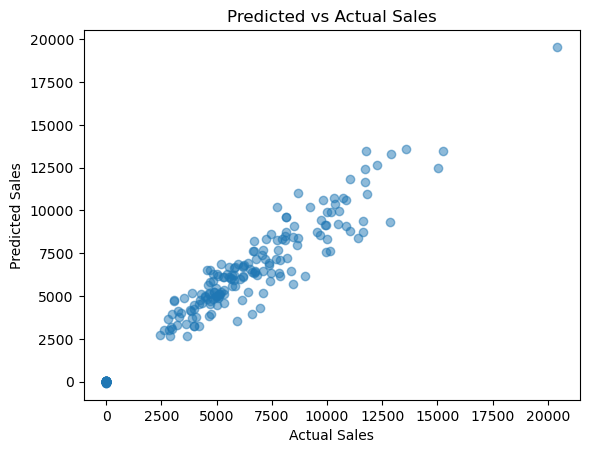

In [219]:
plt.scatter(small_df_label, pred_small_5min, alpha=0.5)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Predicted vs Actual Sales")
plt.show()

In [220]:
big_df_label = big_df["Sales"]
big_df.drop("Sales" , axis = 1)
pred_big_5min = predictor_5min.predict(big_df)
pred_big_5min

138619     6438.373535
39765      6394.760742
173119     7661.506348
53208        22.401636
142984       13.478335
              ...     
23544      9312.299805
123598     6399.911133
113608        8.501698
111861    12707.890625
140261     4421.699707
Name: Sales, Length: 40689, dtype: float32

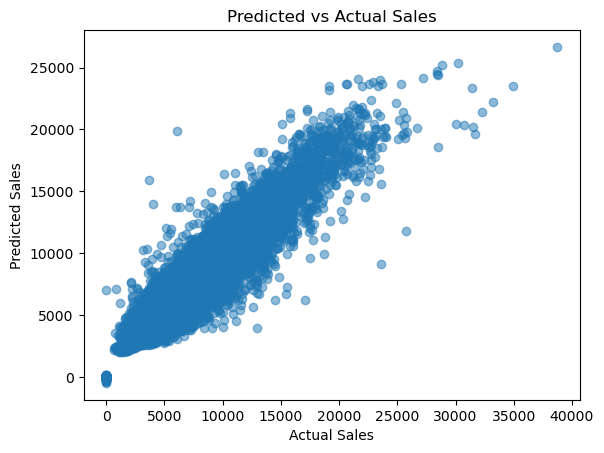

In [221]:
plt.scatter(big_df_label, pred_big_5min, alpha=0.5)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Predicted vs Actual Sales")
plt.show()

In [222]:
# The results still seem to be good!!!
# It seems like the 5 min trained model is performing worse in the small dataset comparing to the big dataset. the errors (RMSE) are slightly different(709, 679).
# The model works slightly better on the big dataset comparing to the small dataset. However it is not enough.

## Non-Startified

In [150]:
data

,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,5263,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,6064,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,8314,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,13995,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,4822,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1
1017205,1112,2,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1
1017206,1113,2,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1
1017207,1114,2,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1


In [151]:
n_splits = 5

split_size = len(data) // n_splits

data_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)

datasets = []
for i in range(n_splits):
    start_idx = i * split_size
    end_idx = (i + 1) * split_size if i < n_splits - 1 else len(data_shuffled)
    datasets.append(data_shuffled.iloc[start_idx:end_idx].reset_index(drop=True))

In [152]:
datasets[0]

,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,616,7,0,0,0,0,0,a,c,3040.0,8.0,2011.0,1,35.0,2010.0,"Mar,Jun,Sept,Dec",2015,5,24,21
1,592,2,5548,1,1,0,1,a,a,2540.0,6.0,2005.0,0,NaN,NaN,NaN,2013,3,26,13
2,526,6,7467,1,0,0,0,a,a,120.0,NaN,NaN,1,48.0,2011.0,"Mar,Jun,Sept,Dec",2013,9,14,37
3,601,2,3360,1,0,0,1,d,a,8220.0,4.0,2014.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2013,7,23,30
4,953,1,11414,1,1,0,0,a,a,19830.0,4.0,2006.0,1,22.0,2011.0,"Mar,Jun,Sept,Dec",2014,12,15,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203436,430,3,10632,1,0,0,0,d,c,12870.0,10.0,2008.0,0,NaN,NaN,NaN,2015,5,13,20
203437,370,6,8822,1,0,0,0,d,a,8250.0,10.0,2000.0,1,31.0,2009.0,"Jan,Apr,Jul,Oct",2014,2,1,5
203438,199,1,11716,1,1,0,0,d,c,6360.0,12.0,2010.0,1,14.0,2012.0,"Mar,Jun,Sept,Dec",2013,8,26,35
203439,1069,6,3375,1,0,0,0,a,c,18050.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,6,27,26


In [153]:
splits = {}

for i, ds in enumerate(datasets):
    train, test = train_test_split(ds, test_size=0.2, random_state=42)  
    splits[f'dataset_{i+1}'] = {'train': train.reset_index(drop=True),
                                 'test': test.reset_index(drop=True)}

In [154]:
X_train_1, X_test_1 = splits['dataset_1']['train'] , splits['dataset_1']['test'] 
X_train_2, X_test_2 = splits['dataset_2']['train'] , splits['dataset_2']['test'] 
X_train_3, X_test_3= splits['dataset_3']['train'] , splits['dataset_3']['test'] 
X_train_4, X_test_4= splits['dataset_4']['train'] , splits['dataset_4']['test'] 
X_train_5, X_test_5= splits['dataset_5']['train'] , splits['dataset_5']['test'] 

In [155]:
X_main_train = pd.concat([X_train_1, X_train_2, X_train_3, X_train_4 , X_train_5]).reset_index(drop=True)
X_main_test = pd.concat([X_test_1, X_test_2, X_test_3, X_test_4, X_test_5]).reset_index(drop=True)

In [156]:
label = 'Sales'
predictor_5min_non= TabularPredictor(label=label, path="AutogluonModels_5min_non/" ).fit(X_main_train,  presets="best" , time_limit = 300 , dynamic_stacking=False)

Preset alias specified: 'best' maps to 'best_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.11
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.4.0: Fri Mar 15 00:19:22 PDT 2024; root:xnu-10063.101.17~1/RELEASE_ARM64_T8112
CPU Count:          8
Memory Avail:       1.49 GB / 8.00 GB (18.6%)
Disk Space Avail:   58.63 GB / 228.27 GB (25.7%)
Presets specified: ['best']
Using hyperparameters preset: hyperparameters='zeroshot'
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "/Users/sepideghorbanian/Documents/Semester_5/Research_Project/AutogluonModels_5min_non"
Train Data Rows:    813764
Train Data Columns: 19
Label Column:       Sales
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column ==

In [157]:
preds = predictor_5min_non.evaluate(X_main_test)
preds

{'root_mean_squared_error': np.float64(-1020.9060449301569),
 'mean_squared_error': -1042249.1875,
 'mean_absolute_error': -665.2911376953125,
 'r2': 0.9291113615036011,
 'pearsonr': 0.9639670211156418,
 'median_absolute_error': -450.61474609375}

In [158]:
X_main_test["Sales"].describe()

count    203445.000000
mean       5770.776102
std        3834.409019
min           0.000000
25%        3733.000000
50%        5745.000000
75%        7854.000000
max       38722.000000
Name: Sales, dtype: float64

In [159]:
small_df = pd.concat([X_test_1[100:150] ,X_test_2[100:150] ,X_test_3[100:150] ,X_test_4[100:150] , X_test_5[100:150]])
preds_small_df = predictor_5min_non.evaluate(small_df)
preds_small_df

{'root_mean_squared_error': np.float64(-921.6747466635063),
 'mean_squared_error': -849484.375,
 'mean_absolute_error': -648.3119506835938,
 'r2': 0.9326648712158203,
 'pearsonr': 0.9659613603634957,
 'median_absolute_error': -452.67919921875}

In [160]:
small_df["Sales"].describe()

count      250.000000
mean      5837.884000
std       3558.993573
min          0.000000
25%       3837.000000
50%       5841.000000
75%       7900.250000
max      19314.000000
Name: Sales, dtype: float64

I think the problem is the data is too incomplex, with only a few categorical features. Also we do the startification which makes all the datsets have almost the same distribution, although the text data is sampeled randomly from the test data but it still migh have the familier patterns. The model learns well and can perform good on both small and big dataset. We still get slightly better evaluation on big datasets but it is not that much. 
Maybe I should try with a dataset that has more categorical features and also more distinct values. 